In [ ]:
import numpy as np
import cv2
import os
import random
from google.colab.patches import cv2_imshow

# **Thresholding**

In [ ]:
# Load the leaf image (replace 'leaf.jpg' with your image file)
image_path = '/content/leaves/DSC_0161.JPG'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur to reduce noise (optional but can be useful)
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# Apply thresholding using an appropriate threshold value
_, thresholded = cv2.threshold(blurred, 100, 255, cv2.THRESH_BINARY)

# Display the original and thresholded images
result = np.hstack((image, thresholded))
cv2_imshow(result)

error: ignored

# **Region based image segmentation**

In [ ]:
# Load the leaf image (replace 'leaf.jpg' with your image file)
image_path = '/content/leaves/DSC_0164.JPG'
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply adaptive thresholding to create a binary image
_, thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Apply morphological operations to clean up the binary image
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, kernel, iterations=2)

# Find sure background region
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Find sure foreground region using distance transform
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Find unknown region (region that is neither foreground nor background)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Create markers for watershed segmentation
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Apply watershed segmentation
markers = cv2.watershed(image, markers)
image[markers == -1] = [0, 0, 255]  # Mark watershed boundaries

# Display the segmented image
cv2_imshow(image)

# **Region growing image segmentation**

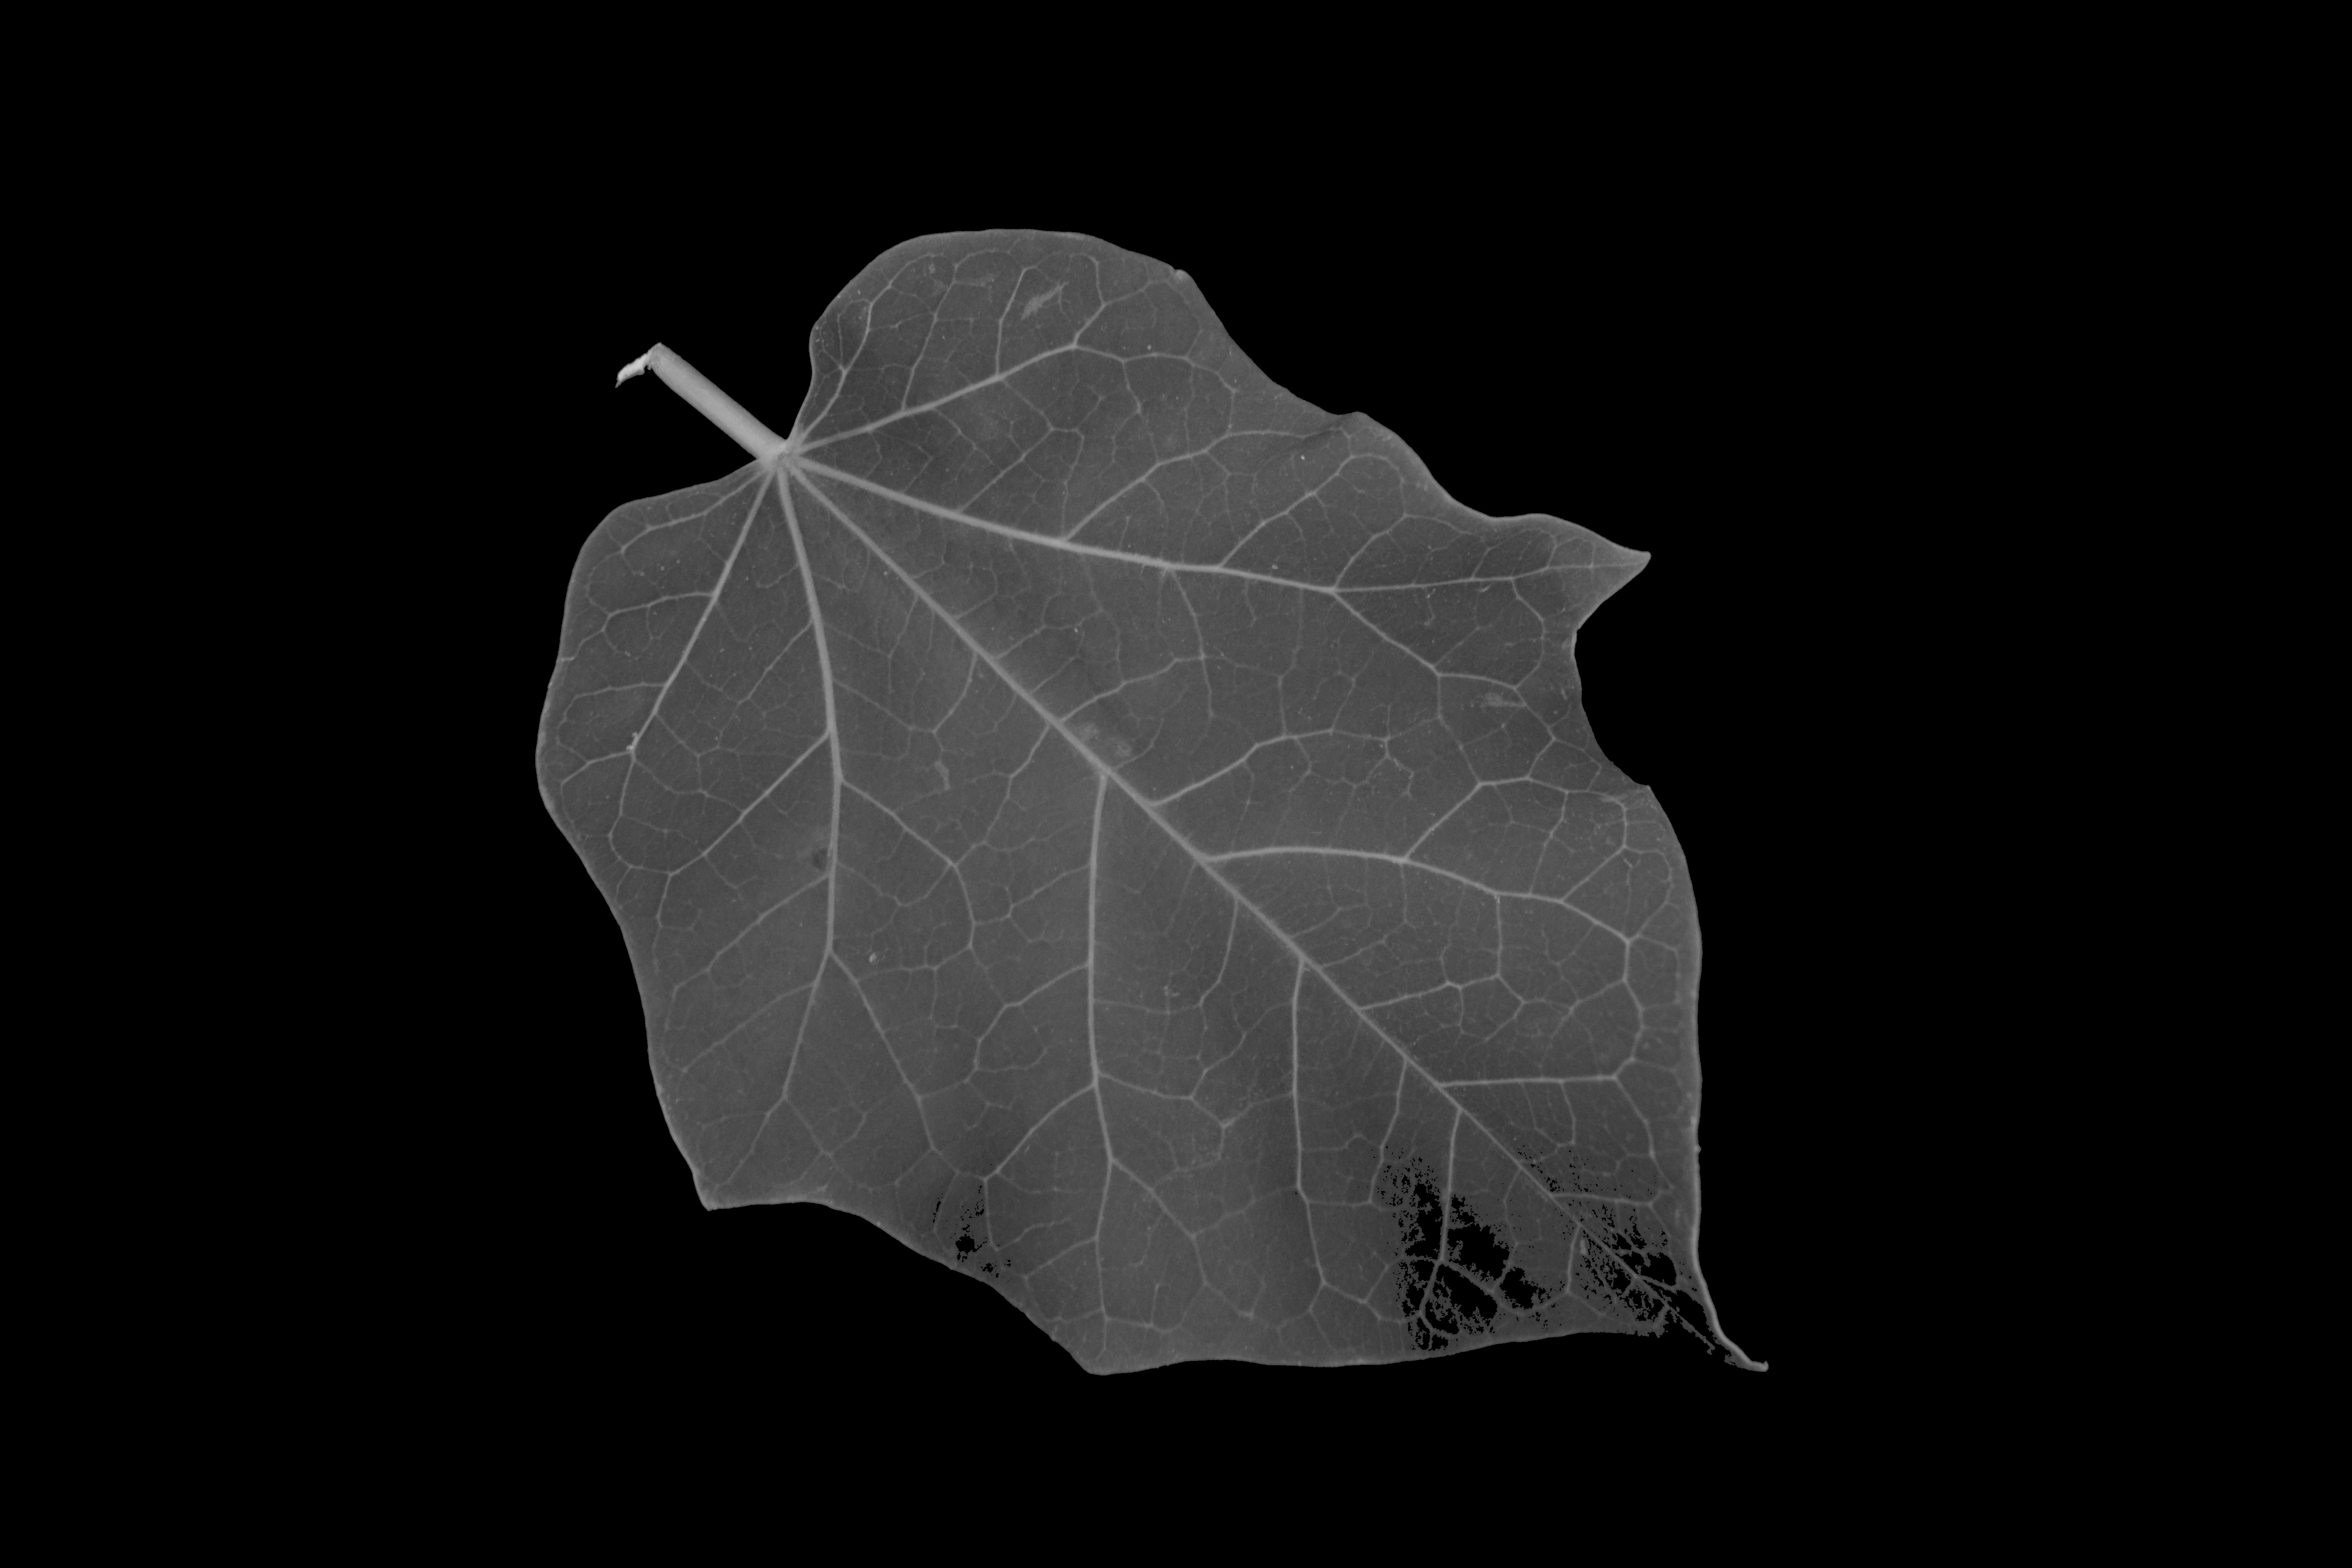

In [ ]:
# Load the leaf image (replace 'leaf.jpg' with your image file)
image_path = '/content/leaves/DSC_0170.JPG'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur to reduce noise (optional but can be useful)
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# Threshold the image to create a binary mask
_, binary_mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Find connected components (regions) in the binary mask
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask)

# Find the largest connected component (excluding the background)
largest_component = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1

# Create a mask for the largest connected component
largest_component_mask = (labels == largest_component).astype(np.uint8) * 255

# Apply bitwise AND to the original image to get the segmented leaf
segmented_leaf = cv2.bitwise_and(image, image, mask=largest_component_mask)

# Display the segmented leaf
cv2_imshow(segmented_leaf)

# **Edge based image segmentation**

In [ ]:
# Load the leaf image (replace 'leaf.jpg' with your image file)
image_path = '/content/leaves/DSC_0179.JPG'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur to reduce noise (optional but can be useful)
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# Apply Canny edge detection
edges = cv2.Canny(blurred, threshold1=30, threshold2=70)

# Display the original image and the edge map
result = np.hstack((image, edges))
cv2_imshow(result)

# **Clustering**

In [ ]:
from sklearn.cluster import KMeans

# Load the leaf image (replace 'leaf.jpg' with your image file)
image_path = '/content/leaves/DSC_0185.JPG'
image = cv2.imread(image_path)

# Convert the image to RGB (OpenCV loads images in BGR format)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Reshape the image to be a list of pixels
pixels = image_rgb.reshape((-1, 3))

# Perform K-Means clustering
num_clusters = 3  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(pixels)

# Get cluster centers (colors)
cluster_centers = kmeans.cluster_centers_

# Assign each pixel to a cluster
labels = kmeans.labels_

# Reshape the labels back to the shape of the original image
segmented = labels.reshape(image.shape[:2])

# Create a mask for each cluster
masks = [(segmented == i).astype(np.uint8) * 255 for i in range(num_clusters)]

# Display the original image and the segmented clusters
cv2_imshow(image)
for i, mask in enumerate(masks):
    cv2_imshow(mask)